In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('fivethirtyeight')

import string
import regex as re
import nltk
import xgboost as xgb
from tqdm import tqdm
from nltk.corpus import stopwords
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras import utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('googleplaystore_user_reviews.csv', sep=',')

In [3]:
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [5]:
df['Sentiment'].unique()

array(['Positive', nan, 'Neutral', 'Negative'], dtype=object)

In [6]:
df['Sentiment'].value_counts(normalize=True)

Positive    0.641109
Negative    0.220961
Neutral     0.137930
Name: Sentiment, dtype: float64

In [7]:
len(df['App'].unique())

1074

In [8]:
df.drop(['App', 'Sentiment_Polarity', 'Sentiment_Subjectivity'], axis=1, inplace=True)
df.dropna(axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
2,Works great especially going grocery store,Positive
3,Best idea us,Positive
4,Best way,Positive


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37427 entries, 0 to 37426
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Translated_Review  37427 non-null  object
 1   Sentiment          37427 non-null  object
dtypes: object(2)
memory usage: 584.9+ KB


In [10]:
print(df.iloc[0]['Translated_Review'])

I like eat delicious food. That's I'm cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"


In [11]:
print('First 10 reviews:\n')

for i in range(10):
    print(str(i+1) + ':', df.iloc[i]['Translated_Review'])

First 10 reviews:

1: I like eat delicious food. That's I'm cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"
2: This help eating healthy exercise regular basis
3: Works great especially going grocery store
4: Best idea us
5: Best way
6: Amazing
7: Looking forward app,
8: It helpful site ! It help foods get !
9: good you.
10: Useful information The amount spelling errors questions validity information shared. Once fixed, 5 stars given.


In [12]:
df['Translated_Review'].value_counts().head(10)

Good         247
Nice         173
Great        131
Love         116
Awesome       71
Very good     69
I love        66
I like        56
good          46
Cool          42
Name: Translated_Review, dtype: int64

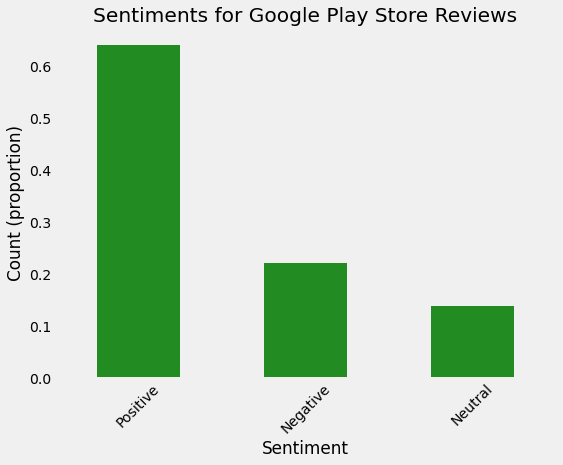

In [13]:
fig = plt.figure(figsize=(8,6))

df['Sentiment'].value_counts(normalize=True).plot(kind='bar', color='forestgreen')
plt.xlabel('Sentiment')
plt.ylabel('Count (proportion)')
plt.title('Sentiments for Google Play Store Reviews')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

In [58]:
REPLACE_HTML_RE = re.compile('https?://\s+|www\.\s+')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = REPLACE_HTML_RE.sub('', text) # delete html address
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [59]:
X = df['Translated_Review'].apply(clean_text)

In [60]:
X.head()

0    like eat delicious food thats im cooking food ...
1           help eating healthy exercise regular basis
2           works great especially going grocery store
3                                         best idea us
4                                             best way
Name: Translated_Review, dtype: object

In [61]:
# tokenize text in corpus

from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

for i in tqdm(range(len(X.values))):
    X.values[i] = tokenizer.tokenize(X.values[i])
    
X.head()

100%|██████████| 37427/37427 [00:03<00:00, 10388.74it/s]


0    [like, eat, delicious, food, thats, im, cookin...
1    [help, eating, healthy, exercise, regular, basis]
2    [works, great, especially, going, grocery, store]
3                                     [best, idea, us]
4                                          [best, way]
Name: Translated_Review, dtype: object

In [22]:
counter = Counter()

for i in tqdm(range(len(X))):
    for word in X[i]:
        counter[word] += 1

counter = dict(counter)
counter

100%|██████████| 37427/37427 [00:00<00:00, 62896.04it/s]


{'like': 5478,
 'eat': 150,
 'delicious': 15,
 'food': 542,
 'thats': 682,
 'im': 2834,
 'cooking': 63,
 'case': 116,
 '10': 518,
 'best': 1962,
 'foods': 133,
 'helps': 345,
 'lot': 1184,
 'also': 2312,
 'shelf': 9,
 'life': 433,
 'help': 960,
 'eating': 71,
 'healthy': 74,
 'exercise': 102,
 'regular': 104,
 'basis': 36,
 'works': 1092,
 'great': 4798,
 'especially': 322,
 'going': 795,
 'grocery': 45,
 'store': 365,
 'idea': 302,
 'us': 573,
 'way': 2019,
 'amazing': 881,
 'looking': 567,
 'forward': 182,
 'app': 4812,
 'helpful': 642,
 'site': 292,
 'get': 4716,
 'good': 5243,
 'useful': 690,
 'information': 517,
 'amount': 342,
 'spelling': 13,
 'errors': 80,
 'questions': 168,
 'validity': 6,
 'shared': 38,
 'fixed': 532,
 '5': 1543,
 'stars': 1188,
 'given': 201,
 'thank': 765,
 'add': 1369,
 'arthritis': 2,
 'eyes': 62,
 'immunity': 2,
 'kidney': 3,
 'liver': 2,
 'detox': 2,
 'please': 2361,
 'greatest': 41,
 'ever': 1020,
 'completely': 326,
 'awesome': 1004,
 'maintain': 24,


In [33]:
# retrieve 10 most frequent words in corpus

from operator import itemgetter

top_10_words = dict(sorted(counter.items(), key = itemgetter(1), reverse = True)[:10])
words = [x for x in top_10_words.keys()]
counts = [x for x in top_10_words.values()]
data = {'words': words, 'counts': counts}
top_10_words = pd.DataFrame(data, columns=['words', 'counts'])
top_10_words

,words,counts
0,game,9288
1,like,5478
2,good,5243
3,app,4812
4,great,4798
5,get,4716
6,love,4658
7,time,4478
8,would,3372
9,cant,3113


No handles with labels found to put in legend.


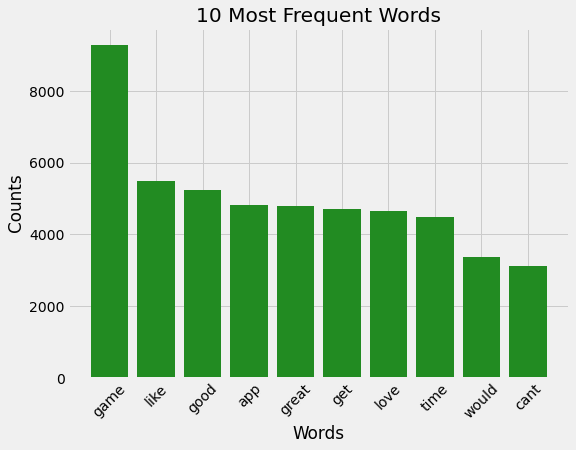

In [47]:
# plot 10 most frequent words in corpus

fig = plt.figure(figsize=(8,6))
plt.bar(top_10_words['words'], top_10_words['counts'], color='forestgreen')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title('10 Most Frequent Words')
plt.legend().set_visible(False)
plt.show()

In [62]:
for i in tqdm(range(len(X.values))):
    X.values[i] = ' '.join(X.values[i]) 

100%|██████████| 37427/37427 [00:00<00:00, 304864.49it/s]


In [63]:
pkl.dump(X, open('X_cleaned.pkl', 'wb'))

In [64]:
df['Translated_Review'].head()

0    I like eat delicious food. That's I'm cooking ...
1      This help eating healthy exercise regular basis
2           Works great especially going grocery store
3                                         Best idea us
4                                             Best way
Name: Translated_Review, dtype: object

In [65]:
X.head()

0    like eat delicious food thats im cooking food ...
1           help eating healthy exercise regular basis
2           works great especially going grocery store
3                                         best idea us
4                                             best way
Name: Translated_Review, dtype: object

In [66]:
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])
y[0:5]

array([2, 2, 2, 2, 2])

In [67]:
pkl.dump(y, open('y.pkl', 'wb'))

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=108,
                                                   test_size=0.2, shuffle=True)

In [69]:
X_train.head()

27802    ads frequent repetitiveso annoying need ad old...
18829                     wonderful gamesits favorite game
29813                                  dont think anything
34438    happy can not phone car make calls understands...
21428               want latest styles for2017 love styles
Name: Translated_Review, dtype: object

In [70]:
y_train[0:5]

array([0, 2, 1, 0, 2])

In [71]:
cv = CountVectorizer(min_df=2, max_df=0.85, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', 
                     ngram_range=(1,3), stop_words='english')

cv.fit(list(X_train) + list(X_test))
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [72]:
tfv = TfidfVectorizer(min_df=2, max_df=0.85, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', 
                     ngram_range=(1,3), stop_words='english')

tfv.fit(list(X_train) + list(X_test))
X_train_tfv = tfv.transform(X_train)
X_test_tfv = tfv.transform(X_test)

In [75]:
lr_cv = LogisticRegression(C=1.0, solver='liblinear')

lr_cv.fit(X_train_cv, y_train)

LogisticRegression(solver='liblinear')

In [76]:
y_cv_pred = lr_cv.predict(X_test_cv)
accuracy = round(accuracy_score(y_test, y_cv_pred), 4)
print('Accuracy Score: {}'.format(accuracy))
print(classification_report(y_test, y_cv_pred))

Accuracy Score: 0.9233
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1654
           1       0.82      0.91      0.86      1032
           2       0.95      0.95      0.95      4800

    accuracy                           0.92      7486
   macro avg       0.90      0.90      0.90      7486
weighted avg       0.92      0.92      0.92      7486



In [77]:
penalty = ['l1', 'l2', 'elasticnet']
max_iter = [100, 150, 200, 250, 300, 375]
C = [1.0, 2.0, 3.0]
param_grid = {'penalty': penalty, 'max_iter': max_iter, 'C': C}

lr_grid = GridSearchCV(lr_cv, param_grid)
lr_grid.fit(X_train_cv, y_train)

GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [1.0, 2.0, 3.0],
                         'max_iter': [100, 150, 200, 250, 300, 375],
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [78]:
pkl.dump(lr_grid, open('lr_grid.pkl', 'wb'))

In [73]:
lr_grid = pkl.load(open('lr_grid.pkl', 'rb'))

In [79]:
print(lr_grid.best_estimator_)
print(lr_grid.best_score_)

LogisticRegression(C=2.0, max_iter=200, penalty='l1', solver='liblinear')
0.9253530492832942


In [33]:
lr_best = lr_grid.predict(X_test_cv)
lr_proba = lr_grid.predict_proba(X_test_cv)

In [34]:
lr_accuracy = round(accuracy_score(y_test, lr_best), 4)
lr_precision = round(precision_score(y_test, lr_best, average='weighted'), 4)
lr_recall = round(recall_score(y_test, lr_best, average='weighted'), 4)
lr_f1 = round(f1_score(y_test, lr_best, average='weighted'), 4)

In [57]:
print('Accuracy Score: {}'.format(accuracy))
print(classification_report(y_test, y_pred_best))

Accuracy Score: 0.914
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1654
           1       0.85      0.93      0.89      1032
           2       0.96      0.95      0.96      4800

    accuracy                           0.93      7486
   macro avg       0.91      0.92      0.92      7486
weighted avg       0.94      0.93      0.93      7486



In [170]:
lr_tfv = LogisticRegression(C=1.0)

lr_tfv.fit(X_train_tfv, y_train)

LogisticRegression()

In [171]:
y_tfv_pred = lr.predict(X_test_tfv)
accuracy = round(accuracy_score(y_test, y_tfv_pred), 2)
print('Accuracy Score: {}'.format(accuracy))
print(classification_report(y_test, y_tfv_pred))

Accuracy Score: 0.43
              precision    recall  f1-score   support

           0       0.98      0.10      0.19      1654
           1       0.20      0.99      0.33      1032
           2       0.97      0.42      0.59      4800

    accuracy                           0.43      7486
   macro avg       0.71      0.51      0.37      7486
weighted avg       0.87      0.43      0.46      7486



In [173]:
NB = MultinomialNB()

NB.fit(X_train_cv, y_train)

MultinomialNB()

In [174]:
y_pred = NB.predict(X_test_cv)
accuracy = round(accuracy_score(y_test, y_pred), 2)
print('Accuracy Score: {}'.format(accuracy))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.79
              precision    recall  f1-score   support

           0       0.82      0.68      0.74      1654
           1       0.68      0.21      0.32      1032
           2       0.78      0.95      0.86      4800

    accuracy                           0.79      7486
   macro avg       0.76      0.61      0.64      7486
weighted avg       0.78      0.79      0.76      7486



In [175]:
XGB = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, subsample=0.8, 
                       nthread=10, learning_rate=0.1)

XGB.fit(X_train_cv, y_train)

[08:16:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=10, nthread=10, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [176]:
y_pred = XGB.predict(X_test_cv)
accuracy = round(accuracy_score(y_test, y_pred), 2)
print('Accuracy Score: {}'.format(accuracy))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.88
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1654
           1       0.71      0.92      0.81      1032
           2       0.93      0.92      0.92      4800

    accuracy                           0.88      7486
   macro avg       0.85      0.86      0.85      7486
weighted avg       0.89      0.88      0.88      7486



In [178]:
svd = TruncatedSVD(n_components=120)
svd.fit(X_train_cv)
X_train_svd = svd.transform(X_train_cv)
X_test_svd = svd.transform(X_test_cv)

In [179]:
scl = StandardScaler()

scl.fit(X_train_svd)
X_train_svd_scl = scl.transform(X_train_svd)
X_test_svd_scl = scl.transform(X_test_svd)

In [180]:
svm = SVC(C=1.0, probability=True)

svm.fit(X_train_svd_scl, y_train)

SVC(probability=True)

In [192]:
pkl.dump(svm, open('svm_1.pkl', 'wb'))

In [181]:
y_pred = svm.predict(X_test_svd_scl)
accuracy = round(accuracy_score(y_test, y_pred), 2)
print('Accuracy Score: {}'.format(accuracy))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.9
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      1654
           1       0.75      0.92      0.82      1032
           2       0.93      0.94      0.94      4800

    accuracy                           0.90      7486
   macro avg       0.87      0.88      0.87      7486
weighted avg       0.91      0.90      0.90      7486



In [14]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=108, max_iter=15, tol=None)

sgd.fit(X_train_cv, y_train)

SGDClassifier(alpha=0.001, max_iter=15, random_state=108, tol=None)

In [38]:
y_pred = sgd.predict(X_test_cv)
accuracy = round(accuracy_score(y_test, y_pred), 4)
print('Accuracy Score: {}'.format(accuracy))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.914
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1654
           1       0.77      0.92      0.84      1032
           2       0.95      0.94      0.95      4800

    accuracy                           0.91      7486
   macro avg       0.88      0.90      0.89      7486
weighted avg       0.92      0.91      0.91      7486



In [16]:
loss = ['hinge', 'squared_hinge']
penalty = ['l1', 'l2']
alpha = [100, 1e-3, 1e-4]
max_iter = [15, 45, 75, 100]

param_grid = {'loss': loss, 'penalty': penalty, 'alpha': alpha, 'max_iter': max_iter}

sgd_grid = GridSearchCV(sgd, param_grid)
sgd_grid.fit(X_train_cv, y_train)

GridSearchCV(estimator=SGDClassifier(alpha=0.001, max_iter=15, random_state=108,
                                     tol=None),
             param_grid={'alpha': [100, 0.001, 0.0001],
                         'loss': ['hinge', 'squared_hinge'],
                         'max_iter': [15, 45, 75, 100],
                         'penalty': ['l1', 'l2']})

In [17]:
pkl.dump(sgd_grid, open('sgd_grid.pkl', 'wb'))

In [35]:
sgd_grid = pkl.load(open('sgd_grid.pkl', 'rb'))

In [36]:
sgd_grid.best_estimator_

SGDClassifier(max_iter=15, random_state=108, tol=None)

In [37]:
sgd_grid.best_score_

0.9128952790648365

In [38]:
sgd_grid.best_params_

{'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 15, 'penalty': 'l2'}

In [39]:
sgd_best = sgd_grid.predict(X_test_cv)

In [40]:
sgd_accuracy = round(accuracy_score(y_test, sgd_best), 4)
sgd_precision = round(precision_score(y_test, sgd_best, average='weighted'), 4)
sgd_recall = round(recall_score(y_test, sgd_best, average='weighted'), 4)
sgd_f1 = round(f1_score(y_test, sgd_best, average='weighted'), 4)

In [41]:
print('Accuracy Score: {}'.format(sgd_accuracy))
print('Precision Score: {}'.format(sgd_precision))
print('Recall Score: {}'.format(sgd_recall))
print('F1 Score: {}\n'.format(sgd_f1))
print(classification_report(y_test, sgd_best))

Accuracy Score: 0.926
Precision Score: 0.9286
Recall Score: 0.926
F1 Score: 0.9264

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1654
           1       0.81      0.94      0.87      1032
           2       0.96      0.95      0.95      4800

    accuracy                           0.93      7486
   macro avg       0.90      0.91      0.90      7486
weighted avg       0.93      0.93      0.93      7486



In [42]:
print('Accuracy Score: {}'.format(lr_accuracy))
print('Precision Score: {}'.format(lr_precision))
print('Recall Score: {}'.format(lr_recall))
print('F1 Score: {}\n'.format(lr_f1))
print(classification_report(y_test, lr_best))

Accuracy Score: 0.9348
Precision Score: 0.9358
Recall Score: 0.9348
F1 Score: 0.935

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1654
           1       0.85      0.93      0.89      1032
           2       0.96      0.95      0.96      4800

    accuracy                           0.93      7486
   macro avg       0.91      0.92      0.92      7486
weighted avg       0.94      0.93      0.94      7486



In [43]:
from sklearn.metrics import confusion_matrix

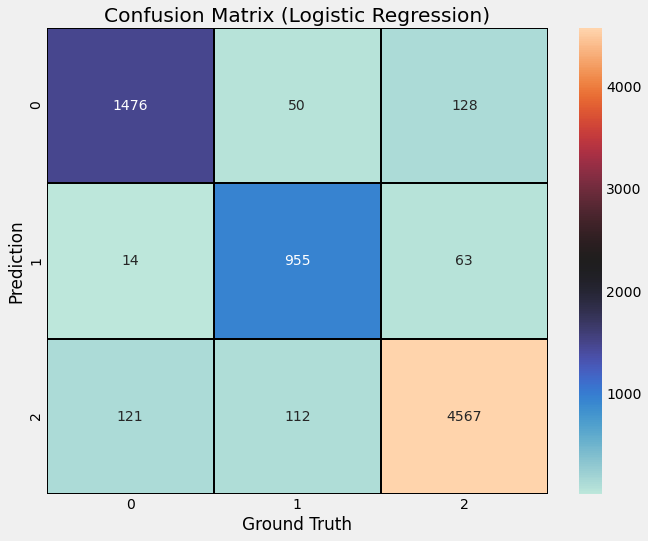

In [44]:
cm = confusion_matrix(y_test, lr_best)

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='icefire', linecolor='black', linewidths=1, fmt='d')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

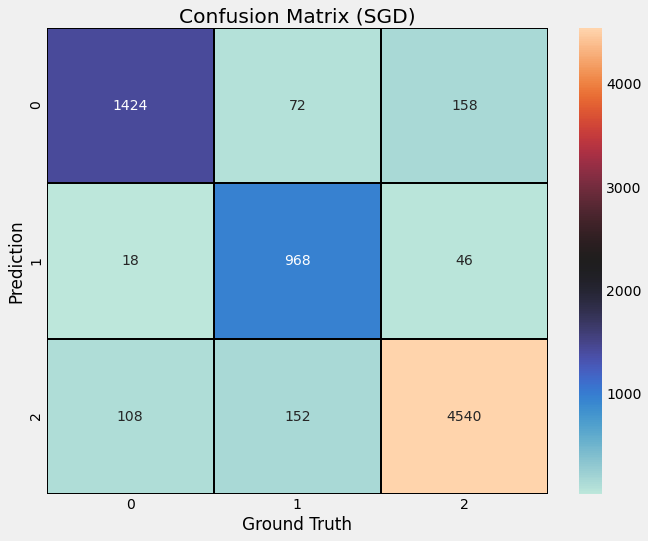

In [45]:
cm = confusion_matrix(y_test, sgd_best)

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='icefire', linecolor='black', linewidths=1, fmt='d')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix (SGD)')
plt.show()

In [49]:
X_train_cv.shape

(29941, 168244)

In [60]:
X = df['Translated_Review'].apply(clean_text)
y = df['Sentiment']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=108, test_size=0.2, shuffle=True)

In [74]:
max_words = 1000
max_len = 70

# tokenize text and covert to sequences
token = text.Tokenizer(num_words=max_words, char_level=False)
token.fit_on_texts(X_train)
X_train_seq = token.texts_to_sequences(X_train)
X_test_seq = token.texts_to_sequences(X_test)

# zero pad sequences
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)
word_index = token.word_index

In [75]:
# encode labels and convert to categorical
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [77]:
# create embedding matrix for words in dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in tqdm(word_index.items()):
    embedding_vector = word_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 21436/21436 [00:00<00:00, 302181.94it/s]


In [80]:
embedding_matrix.shape

(21437, 300)

In [82]:
# LSTM Model 1

model_1 = Sequential()
model_1.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=max_len))
model_1.add(SpatialDropout1D(0.3))
model_1.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model_1.add(Dense(1024, activation='relu'))
model_1.add(Dropout(0.8))
model_1.add(Dense(3))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 300)           6431100   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1024)              103424    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
_________________________________________________________________
activation (Activation)      (None, 3)                

In [83]:
batch_size = 32
epochs = 10

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_1 = model_1.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data
                       =(X_test_pad, y_test))

Epoch 1/10
936/936 [==============================] - 216s 230ms/step - loss: 0.8607 - accuracy: 0.6469 - val_loss: 0.8116 - val_accuracy: 0.6614
Epoch 2/10
936/936 [==============================] - 216s 231ms/step - loss: 0.8347 - accuracy: 0.6541 - val_loss: 0.8091 - val_accuracy: 0.6607
Epoch 3/10
936/936 [==============================] - 217s 232ms/step - loss: 0.8316 - accuracy: 0.6537 - val_loss: 0.8111 - val_accuracy: 0.6535
Epoch 4/10
936/936 [==============================] - 215s 229ms/step - loss: 0.8247 - accuracy: 0.6547 - val_loss: 0.8009 - val_accuracy: 0.6611
Epoch 5/10
936/936 [==============================] - 214s 229ms/step - loss: 0.8247 - accuracy: 0.6552 - val_loss: 0.8068 - val_accuracy: 0.6626
Epoch 6/10
936/936 [==============================] - 227s 243ms/step - loss: 0.8223 - accuracy: 0.6547 - val_loss: 0.8008 - val_accuracy: 0.6624
Epoch 7/10
936/936 [==============================] - 232s 248ms/step - loss: 0.8180 - accuracy: 0.6531 - val_loss: 0.7976 -

In [84]:
# save model and weights to disk

model_1_json = model_1.to_json()
with open("model_1.json", "w") as json_file:
    json_file.write(model_1_json)

model_1.save_weights("model_1.h5")

In [ ]:
# load model and weights to disk

json_file = open('model_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_1 = model_from_json(loaded_model_json)
loaded_model_1.load_weights("model_1.h5")

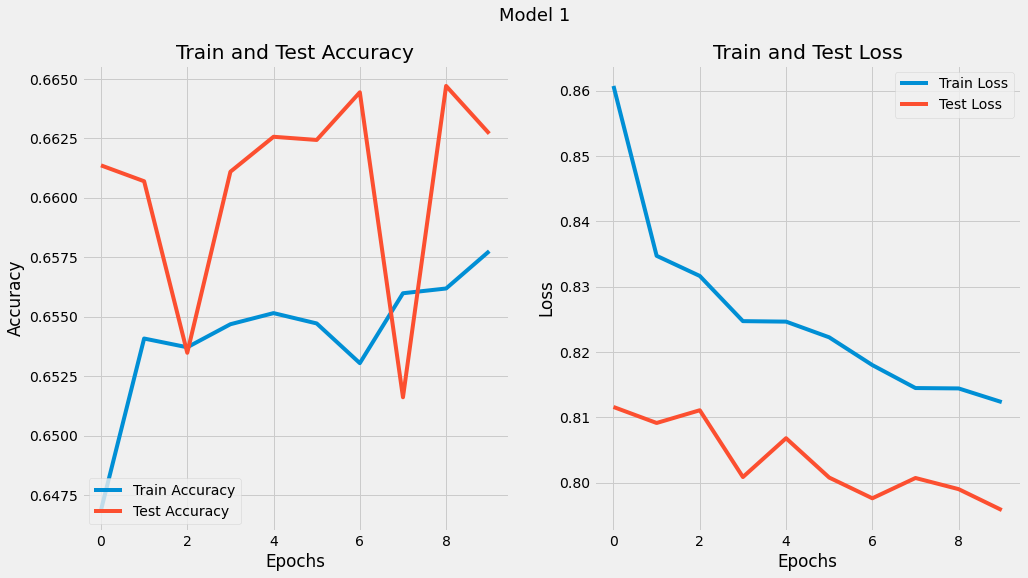

In [86]:
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_range = range(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(epochs_range, acc_1, label='Train Accuracy')
ax1.plot(epochs_range, val_acc_1, label='Test Accuracy')
ax1.set_title('Train and Test Accuracy')
ax1.legend(loc='lower left')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(epochs_range, loss_1, label='Train Loss')
ax2.plot(epochs_range, val_loss_1, label='Test Loss')
ax2.set_title('Train and Test Loss')
ax2.legend(loc='upper right')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

fig.suptitle('Model 1', fontsize=18)

plt.savefig('Model 1 Accuracy and Loss.png')

plt.show()

In [87]:
# LSTM Model 2

model_2 = Sequential()
model_2.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=max_len))
model_2.add(SpatialDropout1D(0.2))
model_2.add(LSTM(75, dropout=0.2, recurrent_dropout=0.2))
model_2.add(Dense(1024, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(3))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 300)           6431100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 70, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 75)                112800    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              77824     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
_________________________________________________________________
activation_1 (Activation)    (None, 3)                

In [88]:
from keras.optimizers import Adam

In [89]:
batch_size = 32
epochs = 10

opt = Adam(lr=0.0001)

model_2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history_2 = model_2.fit(X_train_pad, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test_pad, y_test), verbose=1,
              shuffle=True)

Epoch 1/10
936/936 [==============================] - 180s 192ms/step - loss: 0.8666 - accuracy: 0.6507 - val_loss: 0.8496 - val_accuracy: 0.6619
Epoch 2/10
936/936 [==============================] - 181s 193ms/step - loss: 0.8337 - accuracy: 0.6555 - val_loss: 0.8075 - val_accuracy: 0.6619
Epoch 3/10
936/936 [==============================] - 205s 219ms/step - loss: 0.8225 - accuracy: 0.6557 - val_loss: 0.8296 - val_accuracy: 0.6624
Epoch 4/10
936/936 [==============================] - 192s 205ms/step - loss: 0.8159 - accuracy: 0.6552 - val_loss: 0.7993 - val_accuracy: 0.6619
Epoch 5/10
936/936 [==============================] - 188s 201ms/step - loss: 0.8108 - accuracy: 0.6554 - val_loss: 0.7968 - val_accuracy: 0.6623
Epoch 6/10
936/936 [==============================] - 189s 202ms/step - loss: 0.8096 - accuracy: 0.6561 - val_loss: 0.7966 - val_accuracy: 0.66560.8086 - accuracy: - ETA
Epoch 7/10
936/936 [==============================] - 183s 196ms/step - loss: 0.8051 - accuracy: 0.6

In [90]:
# save model and weights to disk

model_2_json = model_2.to_json()
with open("model_1.json", "w") as json_file:
    json_file.write(model_2_json)

model_2.save_weights("model_2.h5")

In [ ]:
# load model and weights to disk

json_file = open('model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_2 = model_from_json(loaded_model_json)
loaded_model_2.load_weights("model_1.h5")

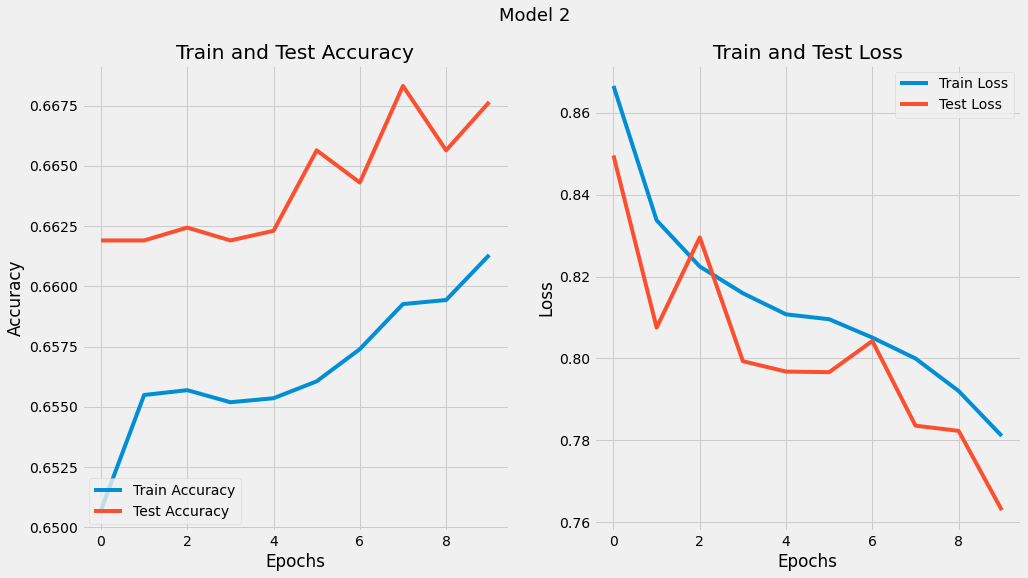

In [91]:
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range = range(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(epochs_range, acc_2, label='Train Accuracy')
ax1.plot(epochs_range, val_acc_2, label='Test Accuracy')
ax1.set_title('Train and Test Accuracy')
ax1.legend(loc='lower left')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(epochs_range, loss_2, label='Train Loss')
ax2.plot(epochs_range, val_loss_2, label='Test Loss')
ax2.set_title('Train and Test Loss')
ax2.legend(loc='upper right')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

fig.suptitle('Model 2', fontsize=18)

plt.savefig('Model 2 Accuracy and Loss.png')

plt.show()